# ---------------------------------------------------------------------
# "Hospital Billing Pathway Optimizer" + Topic Modeling
# ---------------------------------------------------------------------
# We use a real Hospital Billing event log from a Dutch hospital to:
#
#   1. Learn Word2Vec embeddings of billing activities (steps).
#   2. Recommend "next best billing steps" based on learned pathways.
#   3. Discover latent billing pathway types via LDA topic modeling.
#
# This version assumes:
#   - You manually uploaded the .xes (or .xes.gz) file to Colab.
#   - It prints useful outputs after each major step.
#   - It includes visualizations and topic modeling at the end.
#   - Word2Vec is trained more strongly to produce higher similarities.

In [18]:
# ---------------------------------------------------------------------
# 1. Install and import required libraries
# ---------------------------------------------------------------------

print("Step 1: Installing and importing required libraries...")

!pip install -q gensim umap-learn pm4py

import os
import random
import zipfile
import warnings
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import umap.umap_ as umap
import pm4py

warnings.filterwarnings("ignore")

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

plt.rcParams["figure.figsize"] = (6, 4)

print("Libraries successfully installed and imported.")
print("--------------------------------------------------\n")


Step 1: Installing and importing required libraries...
Libraries successfully installed and imported.
--------------------------------------------------



In [19]:
# ---------------------------------------------------------------------
# 2. Locate the manually uploaded Hospital Billing event log (XES)
# ---------------------------------------------------------------------
print("Step 2: Locating your manually uploaded Hospital Billing event log...")

DATA_DIR = "hospital_billing_data"
os.makedirs(DATA_DIR, exist_ok=True)

# 1) Prefer directly uploaded XES / XES.GZ files
xes_files = []
xes_files += glob.glob("*.xes")
xes_files += glob.glob("*.xes.gz")
xes_files += glob.glob("**/*.xes", recursive=True)
xes_files += glob.glob("**/*.xes.gz", recursive=True)

# Deduplicate while preserving order
xes_files = list(dict.fromkeys(xes_files))

if xes_files:
    print("  -> Found the following XES/XES.GZ file(s):")
    for f in xes_files:
        print("     ", f)

    xes_path = xes_files[0]
    print(f"\n  -> Using event log file: {xes_path}")

else:
    # 2) If no XES found, fallback: look for valid ZIPs
    zip_files = glob.glob("*.zip") + glob.glob("**/*.zip", recursive=True)

    if not zip_files:
        raise FileNotFoundError(
            "No .xes / .xes.gz file detected, and no ZIP found.\n"
            "Please upload your hospital billing .xes file via the Files pane."
        )

    print("  -> No direct XES file found.")
    print("  -> Checking ZIP files safely...")

    extracted = False

    for zip_path in zip_files:
        print(f"     Trying ZIP: {zip_path}")
        try:
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(DATA_DIR)
                extracted = True
                print("       Extracted successfully.")
        except zipfile.BadZipFile:
            print("       Not a valid ZIP → skipping.")

    if not extracted:
        raise RuntimeError(
            "ZIP file exists but none are valid archives.\n"
            "Your uploaded file is probably a .xes misnamed as .zip.\n"
            "Prefer uploading the .xes directly."
        )

    # Try locating XES after extraction
    xes_files = glob.glob(os.path.join(DATA_DIR, "*.xes")) + glob.glob(os.path.join(DATA_DIR, "*.xes.gz"))

    if not xes_files:
        raise FileNotFoundError(
            "ZIP extracted, but no .xes / .xes.gz file was found inside.\n"
            "Please check the archive contents."
        )

    xes_path = xes_files[0]
    print(f"\n  -> Using extracted XES file: {xes_path}")

print("Step 2 completed.")
print("--------------------------------------------------\n")


Step 2: Locating your manually uploaded Hospital Billing event log...
  -> Found the following XES/XES.GZ file(s):
      hospital_billing_data.xes
      Hospital Billing - Event Log.xes

  -> Using event log file: hospital_billing_data.xes
Step 2 completed.
--------------------------------------------------



In [20]:
# ---------------------------------------------------------------------
# 3. Load the XES event log into a pandas DataFrame
# ---------------------------------------------------------------------

print("Step 3: Loading XES event log and converting to DataFrame...")

log = pm4py.read_xes(xes_path)
df = pm4py.convert_to_dataframe(log)

print("Visualizing the HEAD of the raw event log (first 5 rows):")
display(df.head())
print()

print("Columns in the event log:")
print(list(df.columns), "\n")

REQUIRED_COLS = ["case:concept:name", "concept:name"]
for col in REQUIRED_COLS:
    if col not in df.columns:
        raise ValueError(f"Required column '{col}' not found in the event log!")

time_col = "time:timestamp" if "time:timestamp" in df.columns else None
if time_col:
    print(f"Using '{time_col}' as timestamp column for ordering events.\n")
else:
    print("WARNING: No 'time:timestamp' column found. Will order only by case_id.\n")

# Rename key columns
df = df.rename(columns={
    "case:concept:name": "case_id",
    "concept:name": "activity"
})
if time_col:
    df = df.rename(columns={time_col: "timestamp"})

print("Shape of event DataFrame:", df.shape)
print("Number of unique cases:", df["case_id"].nunique())
print("Number of unique activities:", df["activity"].nunique())
print("Step 3 completed.")
print("--------------------------------------------------\n")

Step 3: Loading XES event log and converting to DataFrame...


parsing log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

Visualizing the HEAD of the raw event log (first 5 rows):


,isCancelled,diagnosis,time:timestamp,caseType,speciality,org:resource,concept:name,blocked,isClosed,flagD,...,lifecycle:transition,case:concept:name,closeCode,actRed,actOrange,flagC,msgCount,version,msgType,msgCode
0,False,A,2012-12-16 19:33:10,A,A,ResA,NEW,False,True,True,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2013-12-15 19:00:37,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,complete,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2013-12-16 03:53:38,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2013-12-17 12:56:29,NaN,NaN,NaN,CODE OK,NaN,NaN,NaN,...,complete,A,NaN,False,False,False,0.0,A,NaN,NaN
4,NaN,NaN,2013-12-19 03:44:31,NaN,NaN,ResB,BILLED,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columns in the event log:
['isCancelled', 'diagnosis', 'time:timestamp', 'caseType', 'speciality', 'org:resource', 'concept:name', 'blocked', 'isClosed', 'flagD', 'flagB', 'flagA', 'state', 'lifecycle:transition', 'case:concept:name', 'closeCode', 'actRed', 'actOrange', 'flagC', 'msgCount', 'version', 'msgType', 'msgCode'] 

Using 'time:timestamp' as timestamp column for ordering events.

Shape of event DataFrame: (451359, 23)
Number of unique cases: 100000
Number of unique activities: 18
Step 3 completed.
--------------------------------------------------



Step 4: Basic Exploratory Data Analysis (EDA)...
Events per case (summary stats):
count    100000.000000
mean          4.513590
std           2.781998
min           1.000000
25%           2.000000
50%           5.000000
75%           6.000000
max         217.000000
Name: activity, dtype: float64 

Top 10 most frequent activities:
activity
NEW             101289
FIN              74738
RELEASE          70926
CODE OK          68006
BILLED           67448
CHANGE DIAGN     45451
DELETE            8225
REOPEN            4669
CODE NOK          3620
STORNO            2973
Name: count, dtype: int64 



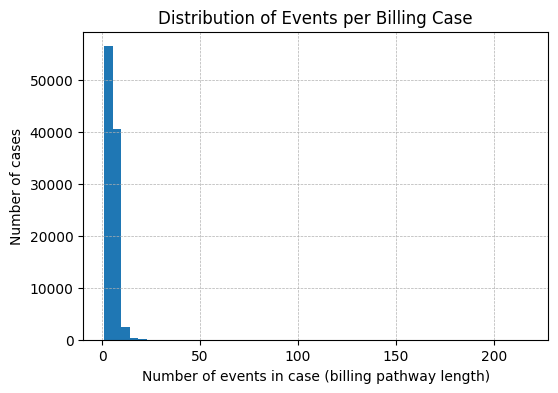

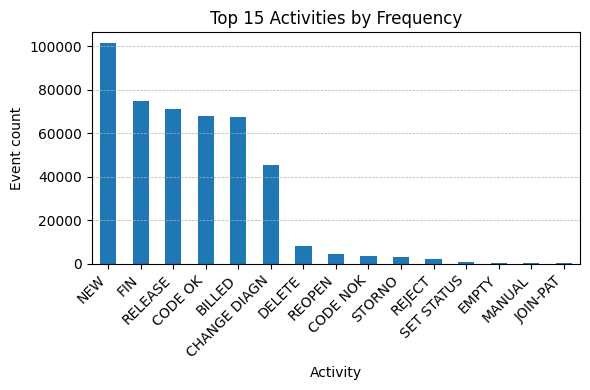

Step 4 completed.
--------------------------------------------------



In [21]:
# ---------------------------------------------------------------------
# 4. Basic EDA: case lengths and activity frequencies
# ---------------------------------------------------------------------

print("Step 4: Basic Exploratory Data Analysis (EDA)...")

events_per_case = df.groupby("case_id")["activity"].count()
activities_freq = df["activity"].value_counts()

print("Events per case (summary stats):")
print(events_per_case.describe(), "\n")

print("Top 10 most frequent activities:")
print(activities_freq.head(10), "\n")

plt.figure()
events_per_case.hist(bins=50)
plt.title("Distribution of Events per Billing Case")
plt.xlabel("Number of events in case (billing pathway length)")
plt.ylabel("Number of cases")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
activities_freq.head(15).plot(kind="bar")
plt.title("Top 15 Activities by Frequency")
plt.xlabel("Activity")
plt.ylabel("Event count")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

print("Step 4 completed.")
print("--------------------------------------------------\n")

Step 5: Filtering to keep only multi-step billing pathways...
Total cases before filtering: 100000
Total cases after filtering (>= 2 events): 77627
Filtered DataFrame shape: (428986, 23) 

HEAD of the FILTERED event log:


,isCancelled,diagnosis,timestamp,caseType,speciality,org:resource,activity,blocked,isClosed,flagD,...,lifecycle:transition,case_id,closeCode,actRed,actOrange,flagC,msgCount,version,msgType,msgCode
0,False,A,2012-12-16 19:33:10,A,A,ResA,NEW,False,True,True,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2013-12-15 19:00:37,NaN,NaN,NaN,FIN,NaN,NaN,NaN,...,complete,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2013-12-16 03:53:38,NaN,NaN,NaN,RELEASE,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2013-12-17 12:56:29,NaN,NaN,NaN,CODE OK,NaN,NaN,NaN,...,complete,A,NaN,False,False,False,0.0,A,NaN,NaN
4,NaN,NaN,2013-12-19 03:44:31,NaN,NaN,ResB,BILLED,NaN,NaN,NaN,...,complete,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


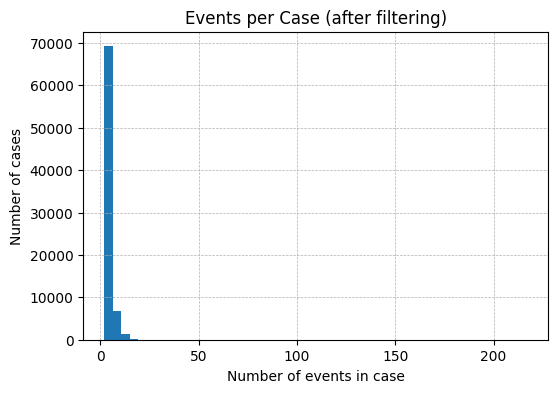

Step 5 completed.
--------------------------------------------------



In [22]:
# ---------------------------------------------------------------------
# 5. Clean & filter: keep only cases with at least 2 events
# ---------------------------------------------------------------------

print("Step 5: Filtering to keep only multi-step billing pathways...")

initial_cases = df["case_id"].nunique()
min_events_per_case = 2

valid_cases = events_per_case[events_per_case >= min_events_per_case].index
df_filtered = df[df["case_id"].isin(valid_cases)].copy()

print(f"Total cases before filtering: {initial_cases}")
print(f"Total cases after filtering (>= {min_events_per_case} events): {df_filtered['case_id'].nunique()}")
print("Filtered DataFrame shape:", df_filtered.shape, "\n")

print("HEAD of the FILTERED event log:")
display(df_filtered.head())
print()

events_per_case_filt = df_filtered.groupby("case_id")["activity"].count()

plt.figure()
events_per_case_filt.hist(bins=50)
plt.title("Events per Case (after filtering)")
plt.xlabel("Number of events in case")
plt.ylabel("Number of cases")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

print("Step 5 completed.")
print("--------------------------------------------------\n")

In [23]:
# ---------------------------------------------------------------------
# 6. Build sequential billing pathways (cases -> ordered activities)
# ---------------------------------------------------------------------

print("Step 6: Constructing ordered billing pathways per case...")

if "timestamp" in df_filtered.columns:
    df_filtered = df_filtered.sort_values(["case_id", "timestamp"]).reset_index(drop=True)
else:
    df_filtered = df_filtered.sort_values(["case_id"]).reset_index(drop=True)

print("HEAD of filtered events used for sequences (first 10 rows):")
display(df_filtered[["case_id", "activity"] + (["timestamp"] if "timestamp" in df_filtered.columns else [])].head(10))
print()

def build_activity_sequences(dataframe, case_col="case_id", act_col="activity"):
    sequences = []
    for cid, group in tqdm(
        dataframe.groupby(case_col),
        total=dataframe[case_col].nunique(),
        desc="Building activity sequences"
    ):
        seq = group[act_col].tolist()
        if len(seq) > 1:
            sequences.append(seq)
    return sequences

all_sequences = build_activity_sequences(df_filtered)

print("\nNumber of billing pathways (cases) used as sequences:", len(all_sequences))
if all_sequences:
    print("Example pathway (first case, up to 15 steps):")
    print("  ->", "  ->  ".join(all_sequences[0][:15]))
    print()

print("Step 6 completed.")
print("--------------------------------------------------\n")

Step 6: Constructing ordered billing pathways per case...
HEAD of filtered events used for sequences (first 10 rows):


,case_id,activity,timestamp
0,A,NEW,2012-12-16 19:33:10
1,A,FIN,2013-12-15 19:00:37
2,A,RELEASE,2013-12-16 03:53:38
3,A,CODE OK,2013-12-17 12:56:29
4,A,BILLED,2013-12-19 03:44:31
5,AA,NEW,2012-12-26 08:50:18
6,AA,CHANGE DIAGN,2012-12-26 08:50:59
7,AA,FIN,2013-02-14 21:06:33
8,AA,RELEASE,2013-02-14 22:12:10
9,AA,CODE OK,2013-02-18 01:44:10


Building activity sequences:   0%|          | 0/77627 [00:00<?, ?it/s]


Number of billing pathways (cases) used as sequences: 77627
Example pathway (first case, up to 15 steps):
  -> NEW  ->  FIN  ->  RELEASE  ->  CODE OK  ->  BILLED

Step 6 completed.
--------------------------------------------------



In [24]:
# ---------------------------------------------------------------------
# 7. Train/Validation split at CASE level
# ---------------------------------------------------------------------

print("Step 7: Splitting cases into train and validation sets...")

unique_cases = df_filtered["case_id"].unique().tolist()
cases_train, cases_val = train_test_split(
    unique_cases, test_size=0.10, random_state=SEED
)

print("Number of train cases:", len(cases_train))
print("Number of validation cases:", len(cases_val), "\n")

df_train = df_filtered[df_filtered["case_id"].isin(cases_train)]
df_val   = df_filtered[df_filtered["case_id"].isin(cases_val)]

print("Train DataFrame shape:", df_train.shape)
print("Validation DataFrame shape:", df_val.shape, "\n")

paths_train = build_activity_sequences(df_train)
paths_val   = build_activity_sequences(df_val)

print("\nNumber of train sequences:", len(paths_train))
print("Number of validation sequences:", len(paths_val))
if paths_train:
    print("Example TRAIN sequence (first 10 activities):")
    print("  ->", "  ->  ".join(paths_train[0][:10]))
    print()

print("Step 7 completed.")
print("--------------------------------------------------\n")



Step 7: Splitting cases into train and validation sets...
Number of train cases: 69864
Number of validation cases: 7763 

Train DataFrame shape: (385858, 23)
Validation DataFrame shape: (43128, 23) 



Building activity sequences:   0%|          | 0/69864 [00:00<?, ?it/s]

Building activity sequences:   0%|          | 0/7763 [00:00<?, ?it/s]


Number of train sequences: 69864
Number of validation sequences: 7763
Example TRAIN sequence (first 10 activities):
  -> NEW  ->  FIN  ->  RELEASE  ->  CODE OK  ->  BILLED

Step 7 completed.
--------------------------------------------------



In [36]:
# ---------------------------------------------------------------------
# 8. Train a stronger Word2Vec model on billing pathways
# ---------------------------------------------------------------------
# To encourage higher similarity scores:
#   - Larger embedding size
#   - Larger window
#   - Lower min_count
#   - More epochs
# ---------------------------------------------------------------------

print("Step 8: Training Word2Vec model on billing activity sequences...")

EMBEDDING_SIZE = 128   # higher dimensional embeddings
WINDOW_SIZE    = 5     # wider context window
MIN_COUNT      = 2     # keep more frequent activities
SG             = 1     # Skip-Gram
EPOCHS         = 50    # more training passes

print("Hyperparameters:")
print(f"  Embedding size : {EMBEDDING_SIZE}")
print(f"  Window size    : {WINDOW_SIZE}")
print(f"  Min count      : {MIN_COUNT}")
print(f"  Architecture   : {'Skip-Gram' if SG == 1 else 'CBOW'}")
print(f"  Epochs         : {EPOCHS}\n")

w2v_model = Word2Vec(
    sentences=paths_train,
    vector_size=EMBEDDING_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    sg=SG,
    workers=4,
    negative=15,
    sample=1e-4,
    epochs=EPOCHS,
    seed=SEED
)

w2v_model.wv.fill_norms()

print("Word2Vec training completed.")
print("Model summary:")
print(w2v_model, "\n")

print("Vocabulary size (activities retained):", len(w2v_model.wv.index_to_key))
print("Sample of activity tokens in the vocabulary:")
print(w2v_model.wv.index_to_key[:10])
print("Step 8 completed.")
print("--------------------------------------------------\n")


Step 8: Training Word2Vec model on billing activity sequences...
Hyperparameters:
  Embedding size : 128
  Window size    : 5
  Min count      : 2
  Architecture   : Skip-Gram
  Epochs         : 50

Word2Vec training completed.
Model summary:
Word2Vec<vocab=17, vector_size=128, alpha=0.025> 

Vocabulary size (activities retained): 17
Sample of activity tokens in the vocabulary:
['NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CHANGE DIAGN', 'DELETE', 'REOPEN', 'CODE NOK', 'STORNO']
Step 8 completed.
--------------------------------------------------



Step 9: Visualizing activity embeddings using UMAP...
Embedding matrix shape: (17, 128) 



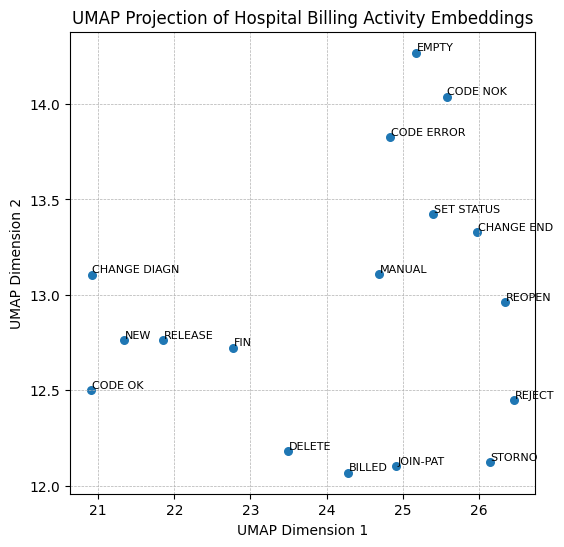

Step 9 completed.
--------------------------------------------------



In [37]:
# ---------------------------------------------------------------------
# 9. Visualize activity embeddings with UMAP (2D projection)
# ---------------------------------------------------------------------

print("Step 9: Visualizing activity embeddings using UMAP...")

activity_tokens = w2v_model.wv.index_to_key
activity_vectors = w2v_model.wv.vectors

print("Embedding matrix shape:", activity_vectors.shape, "\n")

reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1,
    metric="cosine",
    random_state=SEED
)
emb_2d = reducer.fit_transform(activity_vectors)

plt.figure(figsize=(6, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=30)

for i, token in enumerate(activity_tokens):
    plt.text(emb_2d[i, 0] + 0.01, emb_2d[i, 1] + 0.01, token, fontsize=8)

plt.title("UMAP Projection of Hospital Billing Activity Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

print("Step 9 completed.")
print("--------------------------------------------------\n")


In [38]:
# ---------------------------------------------------------------------
# 10. Recommendation utilities (with high-similarity filtering)
# ---------------------------------------------------------------------

print("Step 10: Defining recommendation helper functions with high-sim filtering...\n")

def similar_activities_for_step(activity_name, top_n=5, min_sim=0.6):
    """
    Given an activity name, print and return similar activities.
    We:
      - ask for more neighbors from the model
      - filter to those with similarity >= min_sim
      - then keep the top_n among filtered ones
    """
    if activity_name not in w2v_model.wv.key_to_index:
        print(f"Activity '{activity_name}' not found in vocabulary.\n")
        return []

    print(f"Activities most similar to '{activity_name}' (similarity >= {min_sim}):\n")
    raw = w2v_model.wv.most_similar(activity_name, topn=top_n * 3)

    filtered = [(act, sim) for act, sim in raw if sim >= min_sim]
    filtered = filtered[:top_n]

    if not filtered:
        print("  No activities reach the similarity threshold.")
        print("  (Try lowering min_sim or inspecting more neighbors.)\n")
        return []

    results = []
    for act, sim in filtered:
        results.append((act, sim))
        print(f"  {act:30s}  (similarity = {sim:.3f})")
    print()
    return results


def aggregate_activity_vectors(activity_sequence):
    """
    Given a list of activities, compute the mean of their embeddings.
    """
    vectors = []
    for act in activity_sequence:
        if act in w2v_model.wv.key_to_index:
            vectors.append(w2v_model.wv[act])
    if not vectors:
        raise ValueError("None of the activities in the sequence are in the model vocabulary.")
    return np.mean(vectors, axis=0)


def recommend_next_steps_for_pathway(activity_sequence, top_n=5, min_sim=0.6):
    """
    Given a partial billing pathway, recommend plausible next steps.
    We filter recommended activities by min_sim to prefer higher scores.
    """
    print("Current pathway (context steps):")
    print("  ->", "  ->  ".join(activity_sequence))
    print()

    pathway_vector = aggregate_activity_vectors(activity_sequence)
    raw = w2v_model.wv.similar_by_vector(pathway_vector, topn=top_n * 5)

    seen = set(activity_sequence)
    recommendations = []

    print(f"Recommended next steps (similarity >= {min_sim}):\n")
    for act, sim in raw:
        if act in seen:
            continue
        if sim < min_sim:
            continue
        recommendations.append((act, sim))
        print(f"  {act:30s}  (similarity = {sim:.3f})")
        if len(recommendations) >= top_n:
            break

    if not recommendations:
        print("  No activities reach the similarity threshold.")
        print("  (Try lowering min_sim or using more context steps.)\n")

    print()
    return recommendations

print("Helper functions defined.")
print("Step 10 completed.")
print("--------------------------------------------------\n")


Step 10: Defining recommendation helper functions with high-sim filtering...

Helper functions defined.
Step 10 completed.
--------------------------------------------------



In [39]:
# ---------------------------------------------------------------------
# 11. Example 1: Activity-level similarity (single step)
# ---------------------------------------------------------------------

print("Step 11: Example — activities similar to a given billing step...\n")

example_activity = random.choice(activity_tokens)
print(f"Randomly chosen reference activity: '{example_activity}'\n")
_ = similar_activities_for_step(example_activity, top_n=7, min_sim=0.6)

print("Step 11 completed.")
print("--------------------------------------------------\n")



Step 11: Example — activities similar to a given billing step...

Randomly chosen reference activity: 'REOPEN'

Activities most similar to 'REOPEN' (similarity >= 0.6):

  CODE ERROR                      (similarity = 0.783)
  CHANGE END                      (similarity = 0.677)
  STORNO                          (similarity = 0.667)
  REJECT                          (similarity = 0.612)

Step 11 completed.
--------------------------------------------------



In [40]:
# ---------------------------------------------------------------------
# 12. Example 2: Recommend next steps for a real validation pathway
# ---------------------------------------------------------------------

print("Step 12: Example — recommend next steps for an ongoing billing case...\n")

if paths_val:
    example_path = random.choice(paths_val)

    # Use last K steps as context for "what comes next"
    K = min(4, len(example_path))
    context_steps = example_path[-K:]

    print("Example validation pathway (first 10 steps):")
    print("  ->", "  ->  ".join(example_path[:10]))
    print()

    _ = recommend_next_steps_for_pathway(context_steps, top_n=7, min_sim=0.6)
else:
    print("No validation sequences found. Try adjusting filters or rerunning.\n")

print("Step 12 completed.")
print("--------------------------------------------------\n")


Step 12: Example — recommend next steps for an ongoing billing case...

Example validation pathway (first 10 steps):
  -> NEW  ->  CHANGE DIAGN  ->  FIN  ->  RELEASE  ->  CODE OK  ->  BILLED

Current pathway (context steps):
  -> FIN  ->  RELEASE  ->  CODE OK  ->  BILLED

Recommended next steps (similarity >= 0.6):

  NEW                             (similarity = 0.726)
  DELETE                          (similarity = 0.666)
  MANUAL                          (similarity = 0.605)

Step 12 completed.
--------------------------------------------------



Step 13: Topic modeling on billing pathways (LDA over activities)...

Constructing text corpus: one document per case (activities as tokens)...
Number of documents used for topic modeling: 20000
Example documents (first 3):
   NEW CHANGE DIAGN FIN RELEASE CODE OK BILLED
   NEW FIN RELEASE CODE OK BILLED
   NEW CHANGE DIAGN FIN RELEASE CODE OK BILLED

Vectorizing documents (bag-of-activities)...
Document-term matrix shape: (20000, 15) 

Fitting LDA with 6 topics (this might take a short while)...
LDA training finished.

Top activities per discovered billing-pathway topic:

Topic #0:
  Top activities: change, diagn, delete, end, reopen, reject, storno, status

Topic #1:
  Top activities: storno, reject, change, diagn, reopen, error, end, status

Topic #2:
  Top activities: reopen, manual, error, change, diagn, nok, delete, end

Topic #3:
  Top activities: diagn, change, reopen, nok, error, set, status, manual

Topic #4:
  Top activities: delete, nok, set, status, empty, error, reopen, ch

,case_id,dominant_topic
0,YWCE,3
1,WBU,0
2,EYMC,3
3,OTTB,0
4,BXYB,3
5,OBMB,0
6,OQK,0
7,ONDD,0
8,VCVB,3
9,TJDE,0


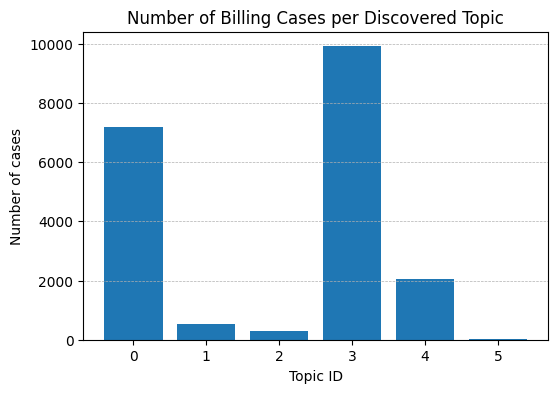

Interpretation notes:
  - Each topic groups billing pathways with similar activity combinations.
  - Top activities per topic hint at process patterns
    (e.g., clean straight-through billing vs complex correction-heavy flows).

Step 13 (Topic Modeling) completed.
--------------------------------------------------



In [41]:
# ---------------------------------------------------------------------
# 13. Topic Modeling: Discover latent *types* of billing pathways
# ---------------------------------------------------------------------

print("Step 13: Topic modeling on billing pathways (LDA over activities)...\n")

print("Constructing text corpus: one document per case (activities as tokens)...")

case_groups = df_filtered.groupby("case_id")["activity"].apply(list)

MAX_DOCS = 20000
if len(case_groups) > MAX_DOCS:
    sampled_case_ids = np.random.choice(case_groups.index, size=MAX_DOCS, replace=False)
    case_groups = case_groups.loc[sampled_case_ids]

texts = [" ".join(acts) for acts in case_groups]

print(f"Number of documents used for topic modeling: {len(texts)}")
print("Example documents (first 3):")
for t in texts[:3]:
    print("  ", t)
print()

print("Vectorizing documents (bag-of-activities)...")
vectorizer = CountVectorizer(
    max_df=0.8,
    min_df=5,
    stop_words=None
)

dtm = vectorizer.fit_transform(texts)
print("Document-term matrix shape:", dtm.shape, "\n")

N_TOPICS = 6
print(f"Fitting LDA with {N_TOPICS} topics (this might take a short while)...")
lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="batch",
    max_iter=25,
    random_state=SEED
)
lda.fit(dtm)
print("LDA training finished.\n")

feature_names = vectorizer.get_feature_names_out()

def print_topics(model, feature_names, n_top_words=8):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_terms = [feature_names[i] for i in top_indices]
        print("  Top activities:", ", ".join(top_terms))
        print()

print("Top activities per discovered billing-pathway topic:\n")
print_topics(lda, feature_names, n_top_words=8)

print("Assigning each billing case a dominant topic...")
doc_topic_dist = lda.transform(dtm)
dominant_topics = doc_topic_dist.argmax(axis=1)

topic_df = pd.DataFrame({
    "case_id": case_groups.index,
    "dominant_topic": dominant_topics
})

print("HEAD of cases with their dominant topics:")
display(topic_df.head(10))
print()

topic_counts = topic_df["dominant_topic"].value_counts().sort_index()

plt.figure()
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.title("Number of Billing Cases per Discovered Topic")
plt.xlabel("Topic ID")
plt.ylabel("Number of cases")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.show()

print("Interpretation notes:")
print("  - Each topic groups billing pathways with similar activity combinations.")
print("  - Top activities per topic hint at process patterns")
print("    (e.g., clean straight-through billing vs complex correction-heavy flows).")
print("\nStep 13 (Topic Modeling) completed.")
print("--------------------------------------------------\n")



In [31]:
# ---------------------------------------------------------------------
# 14. Final summary printout
# ---------------------------------------------------------------------

print("========================================================")
print("END OF NOTEBOOK-STYLE SCRIPT")
print("You now have:")
print("  1) A strongly trained Word2Vec model capturing")
print("     relationships between hospital billing activities.")
print("  2) A 'next best step' recommender that filters to")
print("     higher similarity scores (configurable threshold).")
print("  3) An LDA topic model that reveals major *types* of")
print("     billing pathways, with:")
print("        - top activities printed per topic")
print("        - a bar chart of case counts per topic")
print("  4) Dataset heads and intermediate results printed")
print("     after each major stage for transparency.")
print("========================================================")

END OF NOTEBOOK-STYLE SCRIPT
You now have:
  1) A strongly trained Word2Vec model capturing
     relationships between hospital billing activities.
  2) A 'next best step' recommender that filters to
     higher similarity scores (configurable threshold).
  3) An LDA topic model that reveals major *types* of
     billing pathways, with:
        - top activities printed per topic
        - a bar chart of case counts per topic
  4) Dataset heads and intermediate results printed
     after each major stage for transparency.
